<a href="https://colab.research.google.com/github/snoop2head/OIA_Text_Wrangling/blob/master/_Department_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
print(pd.__version__)
print(np.__version__)

1.1.0
1.18.5


In [2]:
file_name = "department_data.csv"
path = "data_wrangled/" + file_name
df = pd.read_csv(path)
# 데이터의 크기가 어느정도인지 본다.
print(df.shape)
df.sample(5)

(469, 5)


,대학코드,대학명,NUM_VISITS,NUM_DEP,VAR
331,US000088,Iowa State University of Science and Technology,3,3,0.000000
47,CA000022,University of Calgary,6,5,0.160000
301,US000043,Central Washington University,2,2,0.000000
187,JP000012,Kwansei Gakuin University,28,17,0.934256
259,TH000002,Rangsit University,1,1,0.000000


In [3]:
df_data = df.loc[df["NUM_VISITS"]>=6]
df_data.sample(5)

,대학코드,대학명,NUM_VISITS,NUM_DEP,VAR
404,US000207,University of Illinois at Urbana-Champaign,127,41,17.209994
21,AU000019,Australian National University,30,19,0.770083
178,JP000002,Aoyama Gakuin University,41,29,0.725327
92,ES000001,ESADE,24,5,57.760000
168,IL000001,The Hebrew University of Jerusalem,15,10,0.450000


In [4]:
columns_dropping = ["대학코드", "대학명"]
data = df_data.drop(columns=columns_dropping)
data[:5]

,NUM_VISITS,NUM_DEP,VAR
1,40,10,25.600000
3,7,7,0.000000
4,46,15,27.795556
5,13,4,6.187500
6,11,9,0.172840


In [5]:
columns_df = list(df.columns)
columns_data = [column for column in columns_df if column not in columns_dropping]
columns_data

['NUM_VISITS', 'NUM_DEP', 'VAR']

In [6]:
# 정규화
transformer = MinMaxScaler(feature_range=(0, 1))
transformer.fit(data)
x_data = transformer.transform(data)

In [7]:
pd.DataFrame(x_data, columns=columns_data).corr()

,NUM_VISITS,NUM_DEP,VAR
NUM_VISITS,1.000000,0.915019,0.555216
NUM_DEP,0.915019,1.000000,0.328120
VAR,0.555216,0.328120,1.000000


### Variance, Num_visit, Num_dep 갖고 산출한 cluster
종합대, 단과대 라벨이 없기 때문에 비지도학습 기법인 Kmeans Clustering을 진행함.

- 0번 그룹: 전공의 편향도가 높은 그룹, 학생수가 어느 정도 있음
- 1번 그룹: 전공의 편향도가 낮은 그룹, 학생수가 매우 많음
- 2번 그룹: 전공의 편향도가 높은 그룹, 그리고 학생이 적음
- 3번 그룹: 전공의 편향도가 낮고, 학생수가 많음

In [8]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

KElbowVisualizer(ax=<AxesSubplot:>, k=None, model=None)

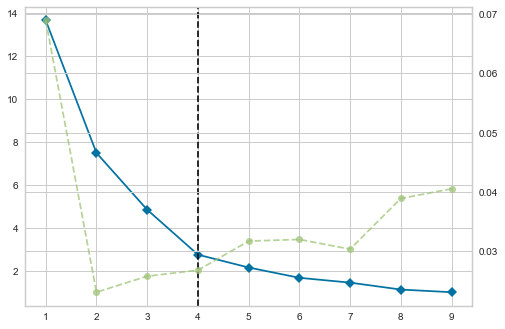

In [9]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(x_data)

In [10]:
# 4개 군집으로 진행
no_clusters = 4
model = KMeans(n_clusters=no_clusters, random_state=307)
model.fit(x_data)

KMeans(n_clusters=4, random_state=307)

In [11]:
cluster_mean = pd.DataFrame(model.cluster_centers_, columns=columns_data)
cluster_mean

,NUM_VISITS,NUM_DEP,VAR
0,0.145507,0.274379,0.043783
1,0.718387,0.670438,0.417782
2,0.027614,0.080750,0.017778
3,0.104137,0.092603,0.393517


In [12]:
df_data['category'] = model.labels_

In [13]:
df_data['category'].value_counts()

2    199
0     73
3     17
1      7
Name: category, dtype: int64

In [14]:
df_data[df_data['category'] == 1]

,대학코드,대학명,NUM_VISITS,NUM_DEP,VAR,category
380,US000172,SUNY at Albany,235,55,81.143802,1
391,US000188,University of California Berkeley,424,103,73.093223,1
393,US000190,University of California Irvine,335,77,94.695227,1
394,US000191,University of California Los Angeles,314,70,54.992653,1
396,US000193,University of California Santa Barbara,358,69,80.964503,1
398,US000195,University of California San Diego,290,70,58.522449,1
437,US000250,University of Washington,188,44,87.334711,1


In [15]:
print("단과대일 수도 있습니다. 본인 전공 수업이 열리는지 잘 확인하세요" , list(df_data[df_data['category'] == 3]["대학코드"].values))

단과대일 수도 있습니다. 본인 전공 수업이 열리는지 잘 확인하세요 ['CA000013', 'CA000020', 'DE000002', 'DE000003', 'ES000001', 'FI000014', 'FR000002', 'IT000001', 'NL000001', 'NL000006', 'NL000010', 'RU000002', 'RU000003', 'SE000001', 'SG000003', 'US000046', 'US000123']


In [16]:
pca = PCA(n_components=2)
pca_fit = pca.fit(x_data)

In [17]:
pca_result = pd.DataFrame(data=pca.fit_transform(x_data))

In [18]:
pca_result['category'] = model.labels_

In [19]:
pca_result[:5]

,0,1,category
0,-0.004694,0.104660,2
1,-0.131490,0.000542,2
2,0.041696,0.091612,2
3,-0.127949,0.042853,2
4,-0.112039,-0.008487,2


In [20]:
pca_result = pca_result.rename(columns={0:'pca1', 1:'pca2'})

In [21]:
# randomly assign colors to the dot
import random
color_lists = []
for i in range(no_clusters):
    color = "%06x" % random.randint(0, 0xFFFFFF)
    color_code = "#" + color
    color_lists.append(color_code)
color_lists

['#01bb7c', '#4f6d15', '#a7d68e', '#f14438']

<AxesSubplot:xlabel='pca1', ylabel='pca2'>

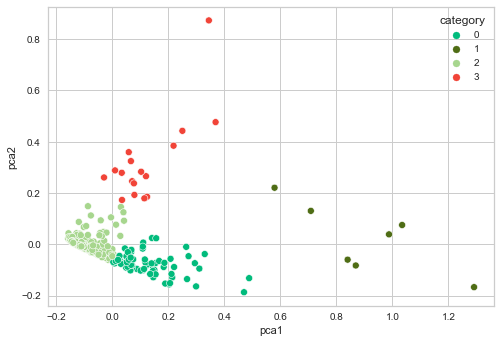

In [22]:
import seaborn as sns
sns.scatterplot(data=pca_result, x='pca1', y='pca2', hue='category', palette=color_lists)